<a href="https://colab.research.google.com/github/kisozipaul/uganda_yield-_prediction-using-cnn-lstm/blob/main/ugandayield.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
pip install rasterio

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten
import rasterio
from tqdm import tqdm
from keras.preprocessing.image import img_to_array, load_img
from keras.applications.vgg16 import preprocess_input
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [53]:
# Specify the folder containing NDVI images
folder_path = '/content/drive/MyDrive/uganda_regions_ndvi'

# Get all TIFF files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith('.tif')]

image_files

['northbuganda3.tif',
 '1.tif',
 '2.tif',
 '3.tif',
 '4.tif',
 '5.tif',
 '6.tif',
 '7.tif',
 '8.tif',
 '9.tif',
 '10.tif',
 '11.tif',
 '12.tif',
 '13.tif',
 '14.tif',
 '23.tif',
 '26.tif',
 '27.tif',
 '19.tif',
 '28.tif',
 '25.tif',
 '21.tif',
 '20.tif',
 '18.tif',
 '16.tif',
 '15.tif',
 '24.tif',
 '22.tif',
 '17.tif',
 '33.tif',
 '42.tif',
 '39.tif',
 '35.tif',
 '37.tif',
 '40.tif',
 '41.tif',
 '34.tif',
 '32.tif',
 '30.tif',
 '29.tif',
 '38.tif',
 '36.tif',
 '31.tif',
 '47.tif',
 '56.tif',
 '53.tif',
 '49.tif',
 '51.tif',
 '54.tif',
 '55.tif',
 '48.tif',
 '46.tif',
 '44.tif',
 '43.tif',
 '52.tif',
 '50.tif',
 '45.tif',
 '61.tif',
 '70.tif',
 '67.tif',
 '63.tif',
 '65.tif',
 '68.tif',
 '69.tif',
 '62.tif',
 '60.tif',
 '58.tif',
 '57.tif',
 '66.tif',
 '64.tif',
 '59.tif',
 '75.tif',
 '84.tif',
 '81.tif',
 '77.tif',
 '79.tif',
 '82.tif',
 '83.tif',
 '76.tif',
 '74.tif',
 '72.tif',
 '71.tif',
 '80.tif',
 '78.tif',
 '73.tif']

In [54]:
# Load the first image to get dimensions
with rasterio.open(os.path.join(folder_path, image_files[0])) as src:
    first_image = src.read()

first_image.shape

(6, 303, 326)

In [55]:
print(first_image)

[[[0.7697 0.7797 0.5692 ... 0.7691 0.7879 0.7879]
  [   nan    nan    nan ... 0.75   0.75   0.765 ]
  [   nan    nan    nan ... 0.7312 0.7349 0.7531]
  ...
  [   nan    nan    nan ...    nan    nan    nan]
  [   nan    nan    nan ...    nan    nan    nan]
  [   nan    nan    nan ...    nan    nan    nan]]

 [[0.1385 0.1385 0.718  ... 0.7389 0.7592 0.7653]
  [   nan    nan    nan ... 0.7428 0.7044 0.7329]
  [   nan    nan    nan ... 0.6977 0.7058 0.7026]
  ...
  [   nan    nan    nan ...    nan    nan    nan]
  [   nan    nan    nan ...    nan    nan    nan]
  [   nan    nan    nan ...    nan    nan    nan]]

 [[0.6527 0.6939 0.6939 ... 0.7591 0.7591 0.7604]
  [   nan    nan    nan ... 0.7214 0.721  0.7512]
  [   nan    nan    nan ... 0.7395 0.7308 0.7424]
  ...
  [   nan    nan    nan ...    nan    nan    nan]
  [   nan    nan    nan ...    nan    nan    nan]
  [   nan    nan    nan ...    nan    nan    nan]]

 [[0.6573 0.6365 0.6365 ... 0.7645 0.7684 0.7684]
  [   nan    nan    nan ..

In [56]:

# Directory where augmented images are saved
ndvi_images_path = '/content/drive/MyDrive/uganda_regions_ndvi/'

# List augmented images
ndvi_images = [f for f in os.listdir(ndvi_images_path) if f.endswith('.tif')]

# Function to preprocess a 6-channel NDVI image
def preprocess_ndvi_image(image_path, target_size):
    with rasterio.open(image_path) as src:
        img = src.read()
    img = np.moveaxis(img, 0, -1)  # Change the dimensions from (channels, height, width) to (height, width, channels)
    img = np.array(img, dtype=np.float32)  # Ensure the image is in float32 format

    # Replace NaN values with a more appropriate value for NDVI
    img = np.nan_to_num(img, nan=-1.0)

    # Clip values to the valid range for NDVI (-1 to 1)
    img = np.clip(img, -1, 1)

    # Resize to the target size
    img_resized = np.resize(img, target_size + (6,))

    # Add batch dimension
    img_batch = np.expand_dims(img_resized, axis=0)

    # Preprocess using VGG16's preprocess function
    img_preprocessed = preprocess_input(img_batch)
    return img_preprocessed

# Define the target size
target_size = (224, 224)


# Load and preprocess all augmented images
ndvi = np.array([preprocess_ndvi_image(os.path.join(ndvi_images_path, img), target_size) for img in ndvi_images])

# Remove the batch dimension (1)
ndvi = ndvi.squeeze(axis=1)


print("Shape of augmented images:", ndvi.shape)


Shape of augmented images: (85, 224, 224, 6)


NDVI stats: nan nan
EVI stats: nan nan


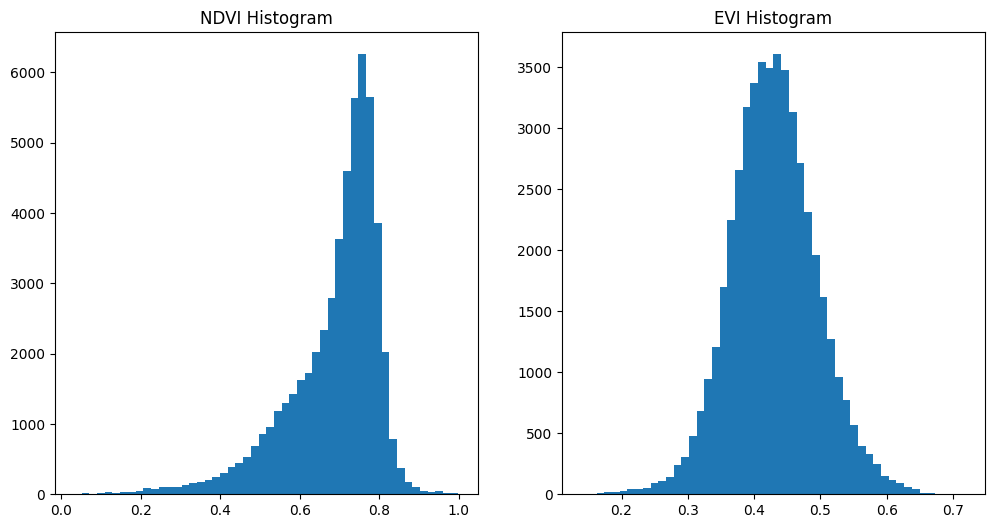

In [99]:


evi_path = '/content/drive/MyDrive/EVI_Data'
ndvi_path = '/content/drive/MyDrive/uganda_regions_ndvi'

def compare_indices(ndvi_path, evi_path):
    ndvi_files = [f for f in os.listdir(ndvi_path) if f.endswith('.tif')]
    evi_files = [f for f in os.listdir(evi_path) if f.endswith('.tif')]

    if not ndvi_files or not evi_files:
        print("No .tif files found in one or both directories.")
        return

    # Use the first file in each directory for this example
    ndvi_file = os.path.join(ndvi_path, ndvi_files[0])
    evi_file = os.path.join(evi_path, evi_files[0])

    with rasterio.open(ndvi_file) as src:
        ndvi = src.read(1)  # Assuming NDVI is in the first band
    with rasterio.open(evi_file) as src:
        evi = src.read(1)  # Assuming EVI is in the first band

    print("NDVI stats:", np.mean(ndvi), np.std(ndvi))
    print("EVI stats:", np.mean(evi), np.std(evi))

    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.hist(ndvi.flatten(), bins=50)
    plt.title("NDVI Histogram")
    plt.subplot(122)
    plt.hist(evi.flatten(), bins=50)
    plt.title("EVI Histogram")
    plt.show()

compare_indices(ndvi_path, evi_path)

In [57]:
# Assuming 'first_image' is already defined and has 6 channels
input_shape = (224, 224, 6)  # Update this shape based on your input images

# Create a new input layer for 6-channel images
input_tensor = Input(shape=input_shape)

# Custom convolutional layer to handle 6 channels
x = Conv2D(3, (1, 1), activation='relu', padding='same', name='custom_conv')(input_tensor)

# Load pre-trained VGG16 model (without the top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Make all VGG16 layers non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Pass the output of the custom layers to the base VGG16 model
x = base_model(x)


# Create the modified model to extract features
model = Model(inputs=input_tensor, outputs=x)

# Print the model summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 6)]     0         
                                                                 
 custom_conv (Conv2D)        (None, 224, 224, 3)       21        
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
Total params: 14714709 (56.13 MB)
Trainable params: 21 (84.00 Byte)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [58]:
# Extract features from the augmented images using the modified VGG16
feature_extractor = model.predict(ndvi)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

# Check the shape of the extracted features
print("Shape of extracted features:", features.shape)


3/3 [==============================] - 69s 17s/step
Shape of extracted features: (85, 25088)


In [59]:
df = pd.read_excel("/content/drive/MyDrive/ubos_yield.xlsx")
df.head()

,years,region,area planted,area harvested,production,yield(MT/ha),yield(MT/ha).1,rainfall,TEMPERATURE
0,2019-01-01,South Buganda,89328,85168.0,127887,1.5,1.4,137.110000,23.223333
1,2019-01-01,North Buganda,198285,175282.0,283621,1.6,1.4,137.110000,23.223333
2,2019-01-01,West Nile,43766,37465.0,45271,1.2,1.0,121.290000,28.046667
3,2019-01-01,Lango,79683,75210.0,92444,1.2,1.2,61.523333,27.100000
4,2019-01-01,Acholi,76779,64740.0,58407,0.9,0.8,68.556667,27.776667


In [60]:
df.shape

(84, 9)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   years           84 non-null     datetime64[ns]
 1   region          84 non-null     object        
 2   area planted    84 non-null     int64         
 3   area harvested  70 non-null     float64       
 4   production      84 non-null     int64         
 5   yield(MT/ha)    84 non-null     float64       
 6   yield(MT/ha).1  56 non-null     float64       
 7   rainfall        84 non-null     float64       
 8   TEMPERATURE     84 non-null     float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 6.0+ KB


In [62]:
df.isnull().sum()

years              0
region             0
area planted       0
area harvested    14
production         0
yield(MT/ha)       0
yield(MT/ha).1    28
rainfall           0
TEMPERATURE        0
dtype: int64

In [63]:
# Remove the specified columns
columns_to_remove = ["area harvested", "area harvested", "yield(MT/ha).1", "production", "region","area planted"]
df2 = df.drop(columns=columns_to_remove)
df2.head()

,years,yield(MT/ha),rainfall,TEMPERATURE
0,2019-01-01,1.5,137.110000,23.223333
1,2019-01-01,1.6,137.110000,23.223333
2,2019-01-01,1.2,121.290000,28.046667
3,2019-01-01,1.2,61.523333,27.100000
4,2019-01-01,0.9,68.556667,27.776667


In [64]:
# Assuming 'features' is already defined and contains the extracted features
num_entries = df2.shape[0]

# Truncate the features to match the number of entries in the dataset
truncated_features = features[:num_entries, :]

print("Shape of truncated features:", truncated_features.shape)


Shape of truncated features: (84, 25088)


In [65]:
# Ensure the dataset has the same number of entries as the truncated features
assert df.shape[0] == truncated_features.shape[0], "Mismatch in number of entries between dataset and truncated features"

# Combine the features with the dataset
data_features = np.hstack((df.values, truncated_features))

# Convert back to DataFrame for easier handling
columns = list(df.columns) + [f'feature_{i}' for i in range(truncated_features.shape[1])]
df3 = pd.DataFrame(data_features, columns=columns)

# Display the combined data
df3.head()


,years,region,area planted,area harvested,production,yield(MT/ha),yield(MT/ha).1,rainfall,TEMPERATURE,feature_0,...,feature_25078,feature_25079,feature_25080,feature_25081,feature_25082,feature_25083,feature_25084,feature_25085,feature_25086,feature_25087
0,2019-01-01,South Buganda,89328,85168.0,127887,1.5,1.4,137.11,23.223333,0.0,...,4.715528,0.0,1.83487,0.0,0.369816,0.410327,0.0,0.0,0.0,0.0
1,2019-01-01,North Buganda,198285,175282.0,283621,1.6,1.4,137.11,23.223333,0.0,...,5.362044,0.0,0.160371,0.0,0.536945,0.506019,0.0,0.0,0.0,0.0
2,2019-01-01,West Nile,43766,37465.0,45271,1.2,1.0,121.29,28.046667,0.0,...,5.072474,0.0,0.285755,0.0,0.569723,0.451509,0.0,0.0,0.0,0.0
3,2019-01-01,Lango,79683,75210.0,92444,1.2,1.2,61.523333,27.1,0.0,...,5.102859,0.0,2.039686,0.0,0.897232,0.0,0.0,0.0,0.0,0.0
4,2019-01-01,Acholi,76779,64740.0,58407,0.9,0.8,68.556667,27.776667,0.0,...,4.882087,0.0,0.0,0.0,0.464849,0.324966,0.0,0.0,0.0,0.0


In [66]:
# Specify the folder containing NDVI images
folder_path = '/content/drive/MyDrive/EVI_Data'

# Get all TIFF files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith('.tif')]
image_files

['5.tif',
 '19.tif',
 '33.tif',
 '47.tif',
 '61.tif',
 '75.tif',
 '14.tif',
 '28.tif',
 '42.tif',
 '70.tif',
 '84.tif',
 '56.tif',
 '11.tif',
 '25.tif',
 '39.tif',
 '53.tif',
 '67.tif',
 '81.tif',
 '7.tif',
 '21.tif',
 '35.tif',
 '49.tif',
 '63.tif',
 '77.tif',
 '9.tif',
 '23.tif',
 '51.tif',
 '37.tif',
 '65.tif',
 '79.tif',
 '12.tif',
 '26.tif',
 '40.tif',
 '54.tif',
 '68.tif',
 '82.tif',
 '13.tif',
 '27.tif',
 '41.tif',
 '55.tif',
 '69.tif',
 '83.tif',
 '6.tif',
 '20.tif',
 '34.tif',
 '48.tif',
 '62.tif',
 '76.tif',
 '4.tif',
 '18.tif',
 '32.tif',
 '46.tif',
 '60.tif',
 '74.tif',
 '2.tif',
 '16.tif',
 '30.tif',
 '44.tif',
 '58.tif',
 '72.tif',
 '1.tif',
 '15.tif',
 '29.tif',
 '43.tif',
 '57.tif',
 '71.tif',
 '10.tif',
 '24.tif',
 '38.tif',
 '52.tif',
 '3.tif',
 '17.tif',
 '31.tif',
 '45.tif',
 '59.tif',
 '73.tif',
 '8.tif',
 '22.tif',
 '36.tif',
 '50.tif',
 '64.tif',
 '78.tif',
 '66.tif',
 '80.tif']

In [67]:
# Load the first image to get dimensions
with rasterio.open(os.path.join(folder_path, image_files[3])) as src:
    first_image2 = src.read()

first_image2.shape

(6, 446, 238)

In [68]:
first_image2

array([[[0.557 , 0.594 , 0.5761, ...,    nan,    nan,    nan],
        [0.5723, 0.6236, 0.5856, ...,    nan,    nan,    nan],
        [0.5981, 0.6539, 0.5856, ...,    nan,    nan,    nan],
        ...,
        [0.4933, 0.4933, 0.4815, ...,    nan,    nan,    nan],
        [0.4606, 0.4606, 0.4861, ...,    nan,    nan,    nan],
        [0.4606, 0.4485, 0.4474, ...,    nan,    nan,    nan]],

       [[0.5146, 0.5418, 0.5693, ...,    nan,    nan,    nan],
        [0.5324, 0.5516, 0.556 , ...,    nan,    nan,    nan],
        [0.5389, 0.5874, 0.5402, ...,    nan,    nan,    nan],
        ...,
        [0.3904, 0.3729, 0.2346, ...,    nan,    nan,    nan],
        [0.4146, 0.3038, 0.3038, ...,    nan,    nan,    nan],
        [0.3455, 0.3455, 0.3455, ...,    nan,    nan,    nan]],

       [[0.4717, 0.4973, 0.4973, ...,    nan,    nan,    nan],
        [0.5481, 0.5353, 0.5353, ...,    nan,    nan,    nan],
        [0.5725, 0.5637, 0.4769, ...,    nan,    nan,    nan],
        ...,
        [0.2

In [69]:


# Directory where augmented images are saved
evi_images_path = '/content/drive/MyDrive/EVI_Data/'

# List augmented images
evi_images = [f for f in os.listdir(evi_images_path) if f.endswith('.tif')]

# Print the list of images to verify
print("List of images in directory:", evi_images)

# Function to preprocess a 6-channel EVI image
def preprocess_evi_image(image_path, target_size):
    if not os.path.exists(image_path):
        print(f"File does not exist: {image_path}")
        return None
    try:
        with rasterio.open(image_path) as src:
            img = src.read()
        img = np.moveaxis(img, 0, -1)  # Change the dimensions from (channels, height, width) to (height, width, channels)
        img = np.array(img, dtype=np.float32)  # Ensure the image is in float32 format

        # Replace NaN values with a more appropriate value for EVI
        img = np.nan_to_num(img, nan=-1.0)

        # Clip values to the valid range for EVI (-1 to 1)
        img = np.clip(img, -1, 1)

        # Normalize EVI to 0-1 range
        img = (img + 1) / 2

        # Resize to the target size
        img_resized = np.resize(img, target_size + (6,))

        # Add batch dimension
        img_batch = np.expand_dims(img_resized, axis=0)

        # Preprocess using VGG16's preprocess function
        img_preprocessed = preprocess_input(img_batch)
        return img_preprocessed
    except rasterio.errors.RasterioIOError as e:
        print(f"Error reading {image_path}: {e}")
        return None

# Define the target size
target_size = (224, 224)

# Load and preprocess all augmented images, skipping any that cause errors
evi_list = [preprocess_evi_image(os.path.join(evi_images_path, img), target_size) for img in evi_images]
evi_list = [img for img in evi_list if img is not None]

# Convert to numpy array and remove the batch dimension (1)
evi = np.array(evi_list).squeeze(axis=1)

print("Shape of augmented images:", evi.shape)


List of images in directory: ['5.tif', '19.tif', '33.tif', '47.tif', '61.tif', '75.tif', '14.tif', '28.tif', '42.tif', '70.tif', '84.tif', '56.tif', '11.tif', '25.tif', '39.tif', '53.tif', '67.tif', '81.tif', '7.tif', '21.tif', '35.tif', '49.tif', '63.tif', '77.tif', '9.tif', '23.tif', '51.tif', '37.tif', '65.tif', '79.tif', '12.tif', '26.tif', '40.tif', '54.tif', '68.tif', '82.tif', '13.tif', '27.tif', '41.tif', '55.tif', '69.tif', '83.tif', '6.tif', '20.tif', '34.tif', '48.tif', '62.tif', '76.tif', '4.tif', '18.tif', '32.tif', '46.tif', '60.tif', '74.tif', '2.tif', '16.tif', '30.tif', '44.tif', '58.tif', '72.tif', '1.tif', '15.tif', '29.tif', '43.tif', '57.tif', '71.tif', '10.tif', '24.tif', '38.tif', '52.tif', '3.tif', '17.tif', '31.tif', '45.tif', '59.tif', '73.tif', '8.tif', '22.tif', '36.tif', '50.tif', '64.tif', '78.tif', '66.tif', '80.tif']
Shape of augmented images: (84, 224, 224, 6)


In [70]:
# Assuming 'first_image' is already defined and has 6 channels
input_shape = (224, 224, 6)  # Update this shape based on your input images

# Create a new input layer for 6-channel images
input_tensor = Input(shape=input_shape)

# Custom convolutional layer to handle 6 channels
x = Conv2D(3, (1, 1), activation='relu', padding='same', name='custom_conv')(input_tensor)

# Load pre-trained VGG16 model (without the top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Make all VGG16 layers non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Pass the output of the custom layers to the base VGG16 model
x = base_model(x)


# Create the modified model to extract features
model = Model(inputs=input_tensor, outputs=x)

# Print the model summary
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 6)]     0         
                                                                 
 custom_conv (Conv2D)        (None, 224, 224, 3)       21        
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
Total params: 14714709 (56.13 MB)
Trainable params: 21 (84.00 Byte)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [71]:
# Extract features from the augmented images using the modified VGG16
feature_extractor2 = model.predict(evi)

features2 = feature_extractor2.reshape(feature_extractor2.shape[0], -1)

# Check the shape of the extracted features
print("Shape of extracted features:", features2.shape)


3/3 [==============================] - 54s 17s/step
Shape of extracted features: (84, 25088)


In [72]:
# Assuming 'features' is already defined and contains the extracted features
num_entries = df3.shape[0]

# Truncate the features to match the number of entries in the dataset
truncated_features2 = features2[:num_entries, :]

print("Shape of truncated features:", truncated_features.shape)


Shape of truncated features: (84, 25088)


In [73]:
# Ensure the dataset has the same number of entries as the truncated features
assert df3.shape[0] == truncated_features2.shape[0], "Mismatch in number of entries between dataset and truncated features"

# Combine the features with the dataset
data_features2 = np.hstack((df3.values, truncated_features2))

# Convert back to DataFrame for easier handling
columns = list(df3.columns) + [f'feature_{i}' for i in range(truncated_features2.shape[1])]
df4 = pd.DataFrame(data_features2, columns=columns)

# Display the combined data
df4.head()


,years,region,area planted,area harvested,production,yield(MT/ha),yield(MT/ha).1,rainfall,TEMPERATURE,feature_0,...,feature_25078,feature_25079,feature_25080,feature_25081,feature_25082,feature_25083,feature_25084,feature_25085,feature_25086,feature_25087
0,2019-01-01,South Buganda,89328,85168.0,127887,1.5,1.4,137.11,23.223333,0.0,...,5.162793,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-01-01,North Buganda,198285,175282.0,283621,1.6,1.4,137.11,23.223333,0.0,...,5.165673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-01-01,West Nile,43766,37465.0,45271,1.2,1.0,121.29,28.046667,0.0,...,5.167845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-01-01,Lango,79683,75210.0,92444,1.2,1.2,61.523333,27.1,0.0,...,5.16723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-01-01,Acholi,76779,64740.0,58407,0.9,0.8,68.556667,27.776667,0.0,...,5.162793,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
# Remove the specified columns
columns_to_remove = ["area harvested", "area harvested", "yield(MT/ha).1", "production", "region","area planted"]
df5 = df4.drop(columns=columns_to_remove)
df5.head()

,years,yield(MT/ha),rainfall,TEMPERATURE,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_25078,feature_25079,feature_25080,feature_25081,feature_25082,feature_25083,feature_25084,feature_25085,feature_25086,feature_25087
0,2019-01-01,1.5,137.11,23.223333,0.0,0.0,0.0,0.0,0.0,0.0,...,5.162793,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-01-01,1.6,137.11,23.223333,0.0,0.0,0.0,0.0,0.0,0.0,...,5.165673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-01-01,1.2,121.29,28.046667,0.0,0.0,0.0,0.0,0.0,0.0,...,5.167845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-01-01,1.2,61.523333,27.1,0.0,0.0,0.0,0.0,0.0,0.0,...,5.16723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-01-01,0.9,68.556667,27.776667,0.0,0.0,0.0,0.0,0.0,0.0,...,5.162793,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Columns: 50180 entries, years to feature_25087
dtypes: datetime64[ns](1), object(50179)
memory usage: 32.2+ MB


In [76]:
cols = list(df5)[1:]
#print(cols)

In [77]:
df_lstm = df5[cols].astype(float)

In [78]:
# Identify columns with 'object' data type
#object_columns = df5.select_dtypes(include=['object']).columns
#print(f"Columns with object data type: {object_columns}")

In [79]:
#for col in object_columns:
    #df5[col] = pd.to_numeric(df5[col], errors='coerce')

In [80]:
df5['years'] = pd.to_datetime(df5['years'])

# Sort the dataframe by date
df5 = df5.sort_values('years')

In [81]:
X = df.drop(['yield(MT/ha)', 'years'], axis=1)
y = df['yield(MT/ha)']
dates = df['years']

In [82]:
# Separate numeric and non-numeric columns
numeric_cols = df5.select_dtypes(include=['number']).columns
non_numeric_cols = df5.select_dtypes(exclude=['number']).columns

In [83]:
numeric_cols

Index([], dtype='object')

In [84]:
non_numeric_cols

Index(['years', 'yield(MT/ha)', 'rainfall', 'TEMPERATURE', 'feature_0',
       'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       ...
       'feature_25078', 'feature_25079', 'feature_25080', 'feature_25081',
       'feature_25082', 'feature_25083', 'feature_25084', 'feature_25085',
       'feature_25086', 'feature_25087'],
      dtype='object', length=50180)

In [85]:
# Convert all columns to numeric, forcing errors to NaN
df_numeric = df5.apply(pd.to_numeric, errors='coerce')

# Drop rows where any element is NaN
df_cleaned = df_numeric.dropna()

# Now the DataFrame df_cleaned should only contain numeric values

# Separate features (X) and the target variable (y) if applicable
# Here, X represents the features; if there is a target variable (y), separate it
X = df_cleaned.values

# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Display the shape of the scaled features
print("Shape of scaled features:", X_scaled.shape)

# Display the first few rows of the scaled data
print(pd.DataFrame(X_scaled).head())

Shape of scaled features: (84, 50180)
   0         1         2         3      4      5      6      7      8      \
0    0.0  0.182013  0.081302  0.133421    0.0    0.0    0.0    0.0    0.0   
1    0.0  0.185212  0.085368  0.380216    0.0    0.0    0.0    0.0    0.0   
2    0.0  0.157297  0.104674  0.416893    0.0    0.0    0.0    0.0    0.0   
3    0.0  0.195899  0.153456  0.466936    0.0    0.0    0.0    0.0    0.0   
4    0.0  0.157762  0.129066  0.030228    0.0    0.0    0.0    0.0    0.0   

   9      ...     50170  50171  50172  50173  50174  50175  50176  50177  \
0    0.0  ...  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1    0.0  ...  0.435689    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2    0.0  ...  0.489603    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3    0.0  ...  0.225652    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4    0.0  ...  0.191388    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   50178  50179  
0    0.0    0.0  
1    0

In [86]:
# Create sequences for LSTM
sequence_length = 5  # Adjust this based on your needs
X_sequences = []
y_sequences = []
dates_sequences = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y.iloc[i+sequence_length])
    dates_sequences.append(dates.iloc[i+sequence_length])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

In [87]:
# Split the data
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X_sequences, y_sequences, dates_sequences, test_size=0.2, random_state=42, shuffle=False)


In [88]:
# Define the LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_sequences.shape[1], X_sequences.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


In [89]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/100
2/2 [==============================] - 7s 1s/step - loss: 4.1218 - val_loss: 1.0544
Epoch 2/100
2/2 [==============================] - 1s 592ms/step - loss: 1.5794 - val_loss: 1.0624
Epoch 3/100
2/2 [==============================] - 1s 567ms/step - loss: 1.5930 - val_loss: 1.2307
Epoch 4/100
2/2 [==============================] - 1s 568ms/step - loss: 1.4643 - val_loss: 1.4170
Epoch 5/100
2/2 [==============================] - 1s 570ms/step - loss: 1.4003 - val_loss: 1.5223
Epoch 6/100
2/2 [==============================] - 1s 646ms/step - loss: 1.1950 - val_loss: 1.5158
Epoch 7/100
2/2 [==============================] - 2s 850ms/step - loss: 1.4221 - val_loss: 1.4210
Epoch 8/100
2/2 [==============================] - 2s 953ms/step - loss: 1.5253 - val_loss: 1.3383
Epoch 9/100
2/2 [==============================] - 2s 968ms/step - loss: 1.2695 - val_loss: 1.2770
Epoch 10/100
2/2 [==============================] - 1s 550ms/step - loss: 1.1775 - val_loss: 1.2426
Epoch 11/100

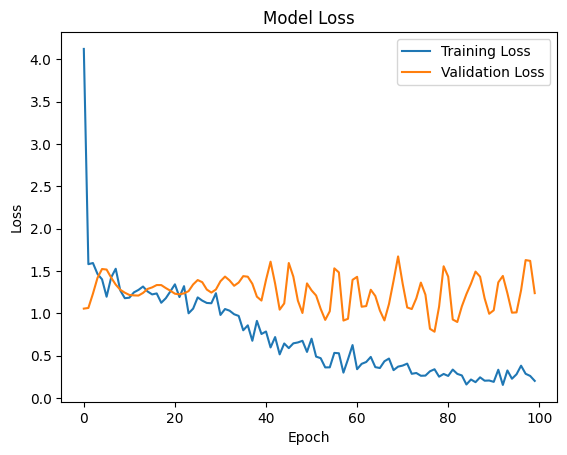

In [90]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [91]:
# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {loss}')


Test loss: 0.6899197101593018


In [92]:
# Make predictions
predictions = model.predict(X_test)

1/1 [==============================] - 1s 882ms/step


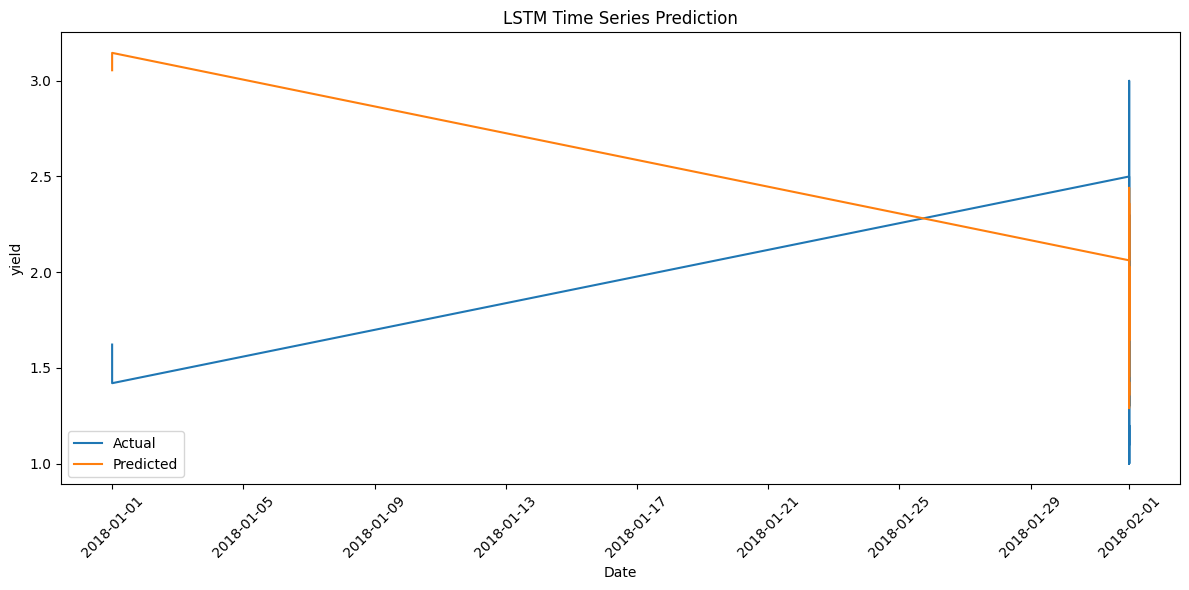

In [93]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test, label='Actual')
plt.plot(dates_test, predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('yield')
plt.title('LSTM Time Series Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [98]:
# Print some sample predictions
print("Sample predictions:")
for date, actual, pred in zip(dates_test[:5], y_test[:5], predictions[:5]):
    print(f"Date: {date}, Actual: {actual}, Predicted: {pred[0]}")

Sample predictions:
Date: 2018-01-01 00:00:00, Actual: 1.6217558288396632, Predicted: 3.055154323577881
Date: 2018-01-01 00:00:00, Actual: 1.4198658649398705, Predicted: 3.1460084915161133
Date: 2018-02-01 00:00:00, Actual: 2.5, Predicted: 2.0618643760681152
Date: 2018-02-01 00:00:00, Actual: 1.7, Predicted: 2.440903663635254
Date: 2018-02-01 00:00:00, Actual: 1.3, Predicted: 2.0724759101867676


In [96]:
# Search for "South Buganda" in all columns
#matches = df5.apply(lambda row: row.astype(str).str.contains('South Buganda', case=False, na=False).any(), axis=1)

# Get the rows where "South Buganda" is found
#south_buganda_rows = df5[matches]

# Display the rows
#print(south_buganda_rows)

# Display specific locations if needed
#for index, row in south_buganda_rows.iterrows():
    #for col in df5.columns:
        #if 'South Buganda' in str(row[col]):
            #print(f"'South Buganda' found at row {index}, column '{col}'")